In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import os

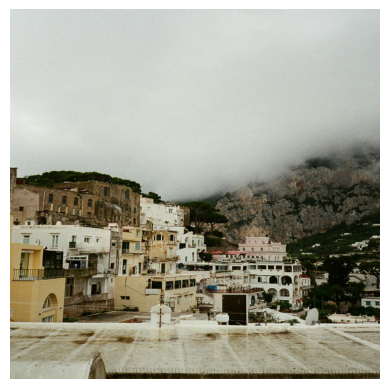

In [2]:
building = Image.open('buildings.jpg')
building = np.array(building)
plt.imshow(building)
plt.axis('off')
plt.show()

In [3]:
building.shape

(1024, 1024, 3)

In [4]:
M = 256
PI = np.pi

# Each needs its own copy
x1 = np.zeros((M, M))
x2 = np.zeros((M, M))
x3 = np.zeros((M, M))

# Horizontal sinusoid
for m in range(M):
    x1[m, :] = np.sin(PI * m * 24 / M)

# Vertical sinusoid
for n in range(M):
    x2[:, n] = np.sin(PI * n * 16 / M)

# Diagonal sinusoid
for m in range(M):
    for n in range(M):
        x3[m, n] = np.sin(2 * PI * (6 * m + 10 * n) / M)

# Combine
x = np.mean([x1, x2, x3], axis=0)


In [5]:
DFT = np.fft.fftshift(np.fft.fft2(x))
DFT_abs = np.abs(DFT)
# full_scale = (DFT_abs-np.min(DFT_abs))/(np.max(DFT_abs) - np.min(DFT_abs))
# full_scale = full_scale.astype(np.uint8)
# full_scale = np.log(1 + full_scale**0.001)
DFT_log = np.log(1 + DFT_abs**0.01)

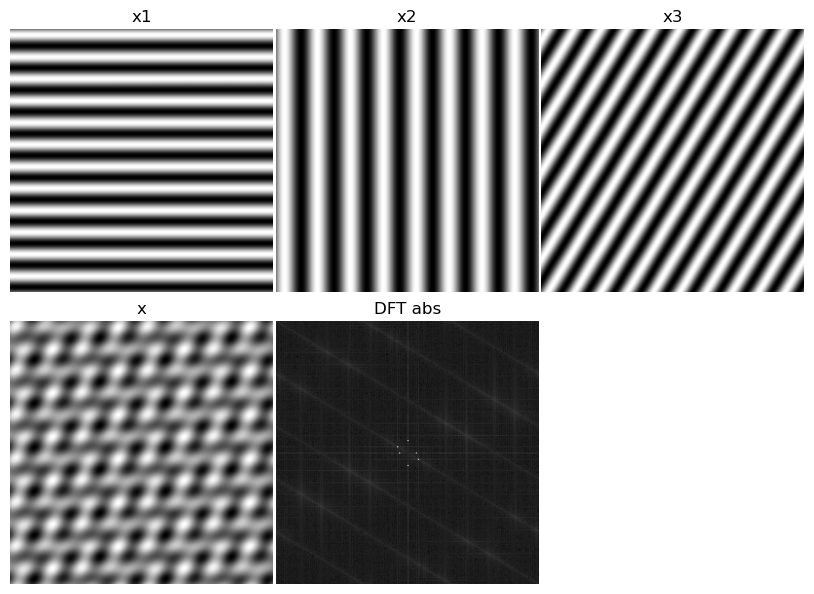

In [6]:
plt.figure(figsize=(8,6))
plt.subplot(2,3,1)
plt.imshow(x1,cmap='gray')
plt.title('x1')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(x2,cmap='gray')
plt.title('x2')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(x3,cmap='gray')
plt.title('x3')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(x,cmap='gray')
plt.title('x')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(DFT_log,cmap='gray')
plt.title('DFT abs')
plt.axis('off')

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.show()

### (b) Design directional filters of size M ×M

In [25]:
def directional_filter(M, W1, W2):
    W1 = np.deg2rad(W1)
    W2 = np.deg2rad(W2)

    u = np.arange(-M//2, M//2)
    v = np.arange(-M//2, M//2)
    U, V = np.meshgrid(u, v)

    angle = np.arctan2(V, U)  # Angle in radians

    D = np.zeros((M, M)) # Initialize the filter mask
    D[(angle >= W1) & (angle <= W2)] = 1
    # if W1 < W2:
    #     D[(angle >= W1) & (angle <= W2)] = 1
    # else:
    #     D[(angle >= W1) | (angle <= W2)] = 1

    return D.astype(np.uint8)


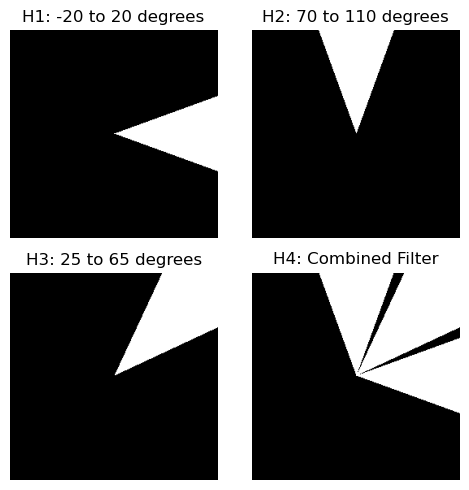

In [30]:
H1 = directional_filter(M,-20, 20)
H2 = directional_filter(M, 70, 110)
H3 = directional_filter(M, 25, 65)
H4 = H1 + H2 + H3
H4[H4 > 1] = 1  #Elementwise maximum value of 1
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
plt.imshow(H1, cmap='gray', origin='lower')
plt.title('H1: -20 to 20 degrees')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(H2, cmap='gray', origin='lower')
plt.title('H2: 70 to 110 degrees')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(H3, cmap='gray', origin='lower')
plt.title('H3: 25 to 65 degrees')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(H4, cmap='gray', origin='lower')
plt.title('H4: Combined Filter')
plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
def display_image(img1, img2, img3, img4, img5, filter_name=''):
    fig, axes = plt.subplots(2, 3, figsize=(9, 7))
    fig.suptitle(f'Directional Filtering using filter {filter_name}', fontsize=14, y=0.95)
    ax = axes.ravel()

    images = [img1, img2, img3, img4, img5]
    titles = [
        "Original Image",
        "Original Image Magnitude Spectrum",
        "Directional Filter Magnitude Spectrum",
        "Filtered Magnitude Spectrum",
        "Reconstructed Filtered Image"
    ]

    for i in range(len(images)):
        ax[i].imshow(images[i], cmap='gray', origin='lower')
        ax[i].set_title(titles[i], fontsize=10)
        ax[i].axis('off')

    # Hide the empty 6th subplot
    fig.delaxes(ax[5])

    # Make the layout tight and compact
    plt.subplots_adjust(
        left=0.03, right=0.97, top=0.90, bottom=0.03,
        wspace=0.1, hspace=0.15
    )

    plt.show()


In [32]:
def directional_filter_image(image,dir_filter):
    M, N = image.shape
    # Compute the 2D DFT of the image and shift the zero frequency component to the center
    DFT = np.fft.fftshift(np.fft.fft2(image))
    DFT_abs = np.abs(DFT)
    DFT_log = np.log(1 + DFT_abs**0.05)

    # Apply the directional filter in the frequency domain
    filtered_DFT = DFT * dir_filter # Element-wise multiplication
    filtered_DFT_abs = np.abs(filtered_DFT)
    filtered_DFT_log = np.log(1 + filtered_DFT_abs**0.05)

    reconstructed_image = np.fft.ifft2(np.fft.ifftshift(filtered_DFT))
    reconstructed_image = np.real(reconstructed_image) # Take real part for display
    reconstructed_image = (reconstructed_image - np.min(reconstructed_image))*255 / (np.max(reconstructed_image) - np.min(reconstructed_image))
    
    return image, DFT_log,dir_filter, filtered_DFT_log, reconstructed_image

In [33]:
image = x
filters = [H1, H2, H3, H4]
reconstructed_images = []

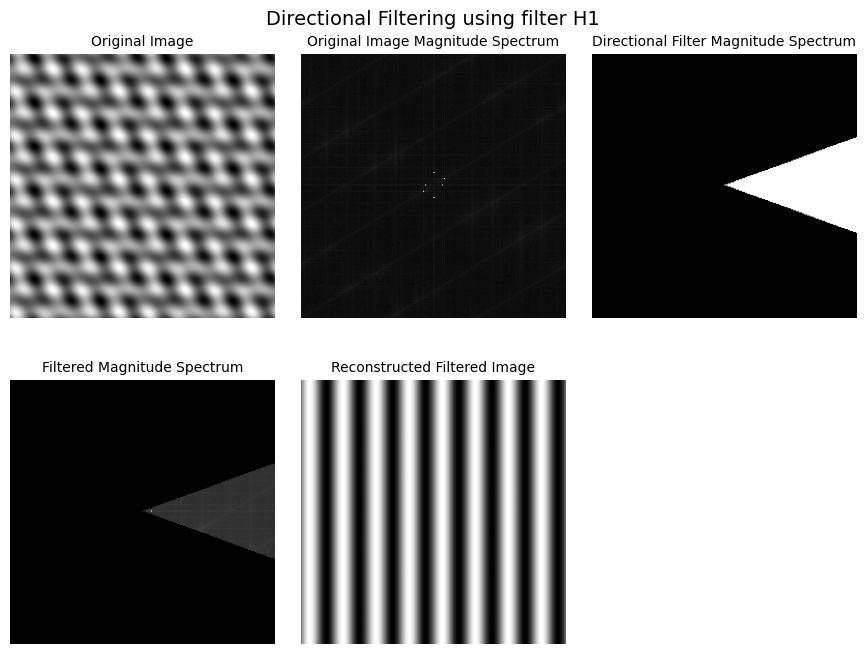

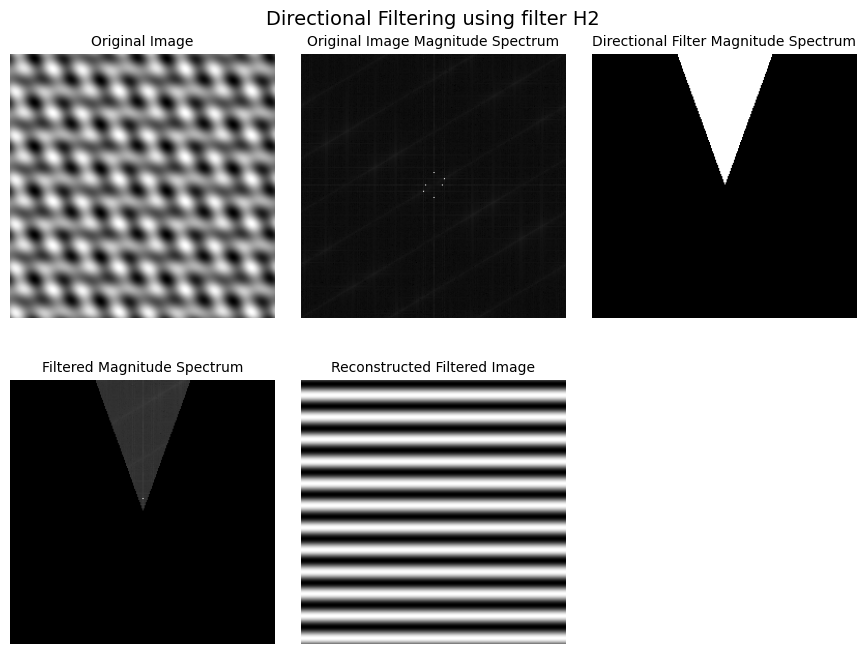

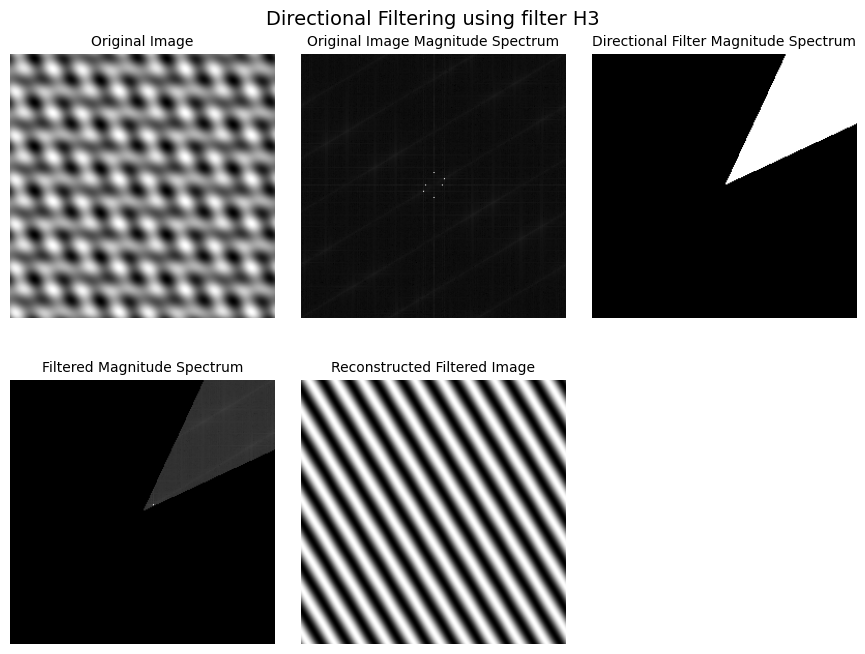

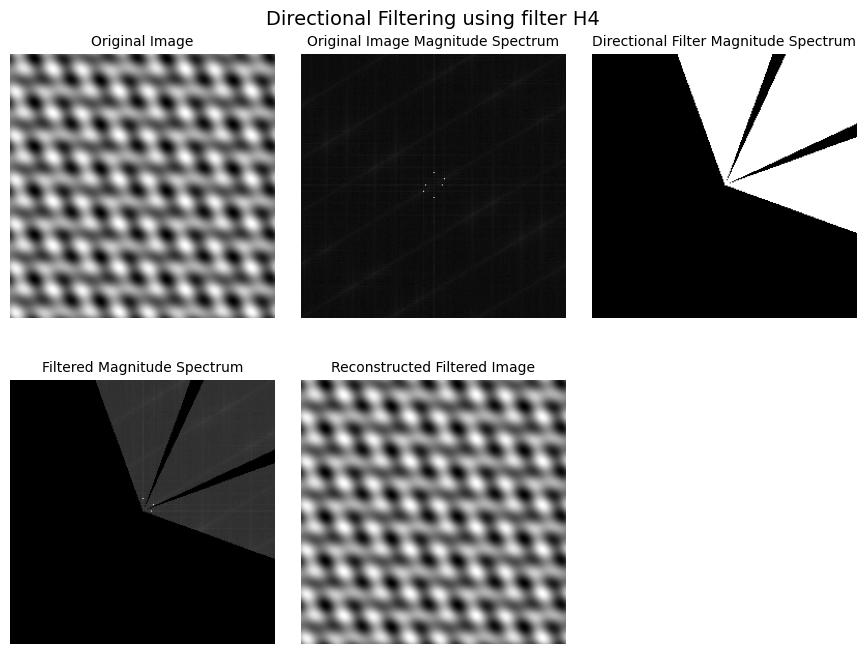

In [34]:
for i,filter in enumerate(filters):
    orig_img, orig_mag_spec, filter, filtered_mag_spec, recon_img = directional_filter_image(image, filter)
    reconstructed_images.append(recon_img)
    display_image(orig_img, orig_mag_spec, filter, filtered_mag_spec, recon_img, filter_name=(f'H{i+1}'))

### C. Compute Mean Squared Error(MSE)

In [35]:
mse = []
for recon_img in reconstructed_images:
    error = np.mean((image - recon_img) ** 2)
    mse.append(error)

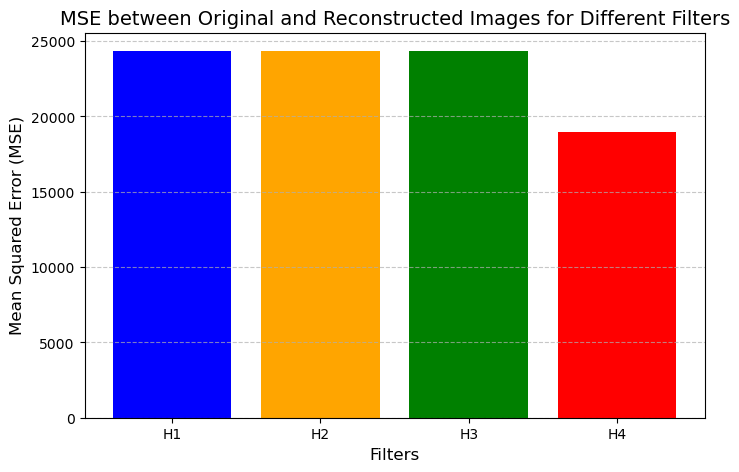

In [36]:
plt.figure(figsize=(8,5))
plt.bar(['H1', 'H2', 'H3', 'H4'], mse, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Filters', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('MSE between Original and Reconstructed Images for Different Filters', fontdict={'fontsize': 14})
plt.show()

## Gaussian Blurring and Inverse Filtering:

In [37]:
x = np.arange(-6,7)
y = np.arange(-6,7)
X, Y = np.meshgrid(x, y)
sigma = 2.5
G = np.exp(-(X**2 + Y**2) / (2 * sigma **2))/np.sum(np.exp(-(X**2 + Y**2) / (2 * sigma **2)))

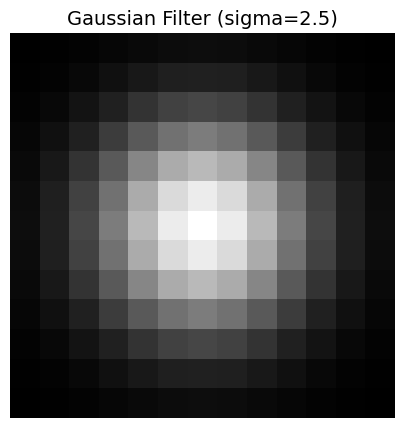

In [38]:
plt.figure(figsize=(5,5))
plt.imshow(G, cmap='gray')
plt.title('Gaussian Filter (sigma=2.5)', fontsize=14)
plt.axis('off')
plt.show()

In [39]:
F = np.fft.fft2(building) # Compute the 2D DFT of the image
F = np.fft.fftshift(F) # Shift the zero frequency component to the center

In [60]:
def frequency_domain_blur(image, kernel):
    H, W, C = image.shape

    # Step 1: Pad and center the Gaussian kernel
    kh, kw = kernel.shape
    padded_kernel = np.zeros((H, W))
    padded_kernel[:kh, :kw] = kernel # zero-pad kernel to image size. kernel is at top-left corner
    padded_kernel = np.fft.ifftshift(padded_kernel)  # center kernel

    H_uv = np.fft.fft2(padded_kernel) #FFT of the kernel

    blurred_channels = []

    for c in range(C):
        F_uv = np.fft.fft2(image[:, :, c]) #FFT of the image channel

        G_uv = F_uv * H_uv # Apply Gaussian blur in frequency domain

        g_xy = np.real(np.fft.ifft2(G_uv)) # Reconstruct blurred image (inverse DFT)

        blurred_channels.append(g_xy)

    blurred_image = np.stack(blurred_channels, axis=2)
    blurred_image = np.clip(blurred_image, 0, 255).astype(np.uint8)

    return blurred_image


In [61]:
freq_domain_blur = frequency_domain_blur(F, G)

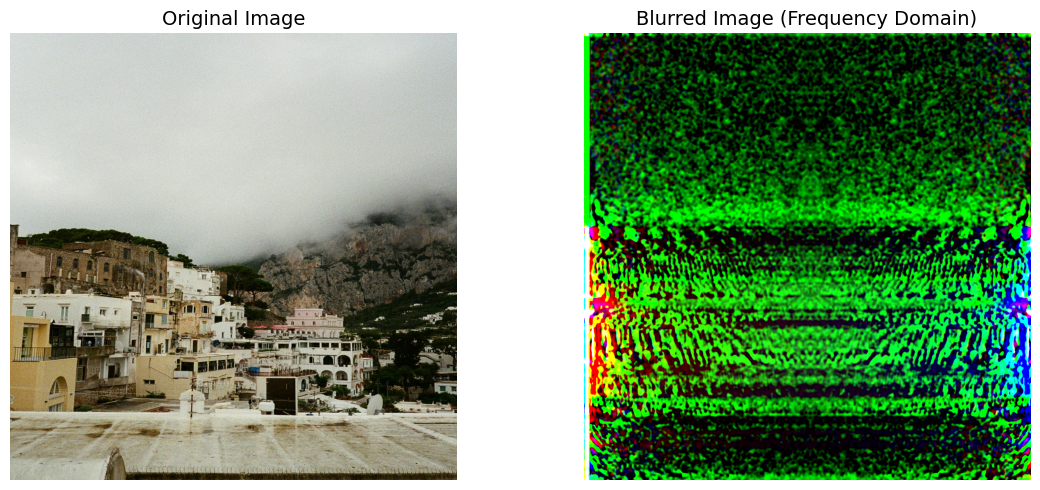

In [62]:
# Display results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(building)
plt.title('Original Image', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(freq_domain_blur)
plt.title('Blurred Image (Frequency Domain)', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

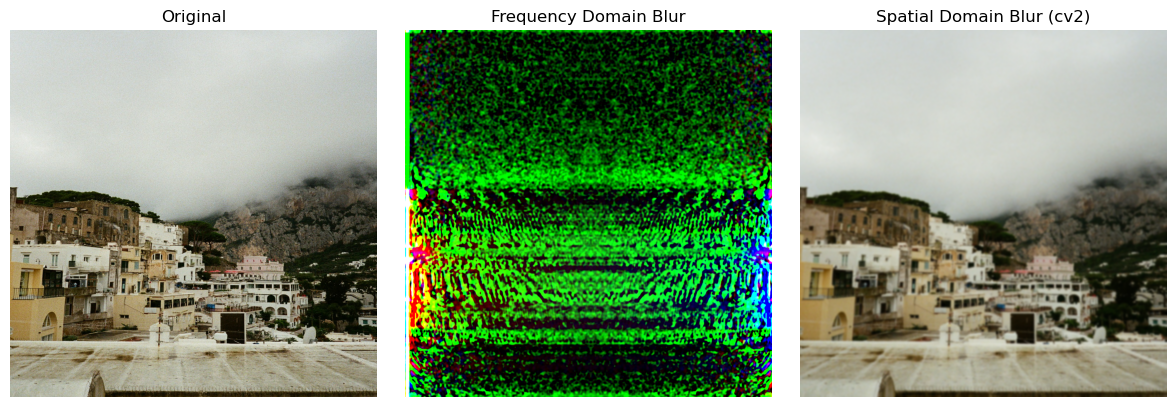

In [88]:
spatial_blur = cv2.GaussianBlur(building, (13, 13), 2.5)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(building, cmap='gray')
plt.title('Original', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(freq_domain_blur, cmap='gray')
plt.title('Frequency Domain Blur', fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(spatial_blur, cmap='gray')
plt.title('Spatial Domain Blur (cv2)', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

### b

In [43]:
Huv = np.fft.fft2(G, s = G.shape)
Huv_centered = np.fft.fftshift(Huv)
Huv_abs = np.abs(Huv_centered)
Huv_log = np.log10(1 + Huv_abs**0.01)
inv_Huv = 1/(Huv_abs + 1e-3) 

In [44]:
inv_Huv_full_scale = (inv_Huv - np.min(inv_Huv)) / (np.max(inv_Huv) - np.min(inv_Huv))
inv_Huv_full_scale = (inv_Huv_full_scale * 255).astype(np.uint8)

In [45]:
Mpt = 1036
pad_left_width, pad_right_width = (Mpt - G.shape[0]) // 2, (Mpt - G.shape[0]) - (Mpt - G.shape[0]) // 2
pad_top_width, pad_bottom_width = (Mpt - G.shape[1]) // 2, (Mpt - G.shape[1]) - (Mpt - G.shape[1]) // 2
padded_G = np.pad(G, ((pad_left_width, pad_right_width), (pad_top_width, pad_bottom_width)), mode='constant', constant_values=0)
padded_G_centered = np.fft.fftshift(np.fft.fft2(padded_G))
padded_G_abs = np.abs(padded_G_centered)
padded_G_log = np.log10(1 + padded_G_abs**0.01)
inv_padded_G = 1/(padded_G_abs + 1e-3)

In [46]:
inv_padded_G_abs_full_scale = (inv_padded_G - np.min(inv_padded_G)) / (np.max(inv_padded_G) - np.min(inv_padded_G))
inv_padded_G_abs_full_scale = (inv_padded_G_abs_full_scale * 255).astype(np.uint8)

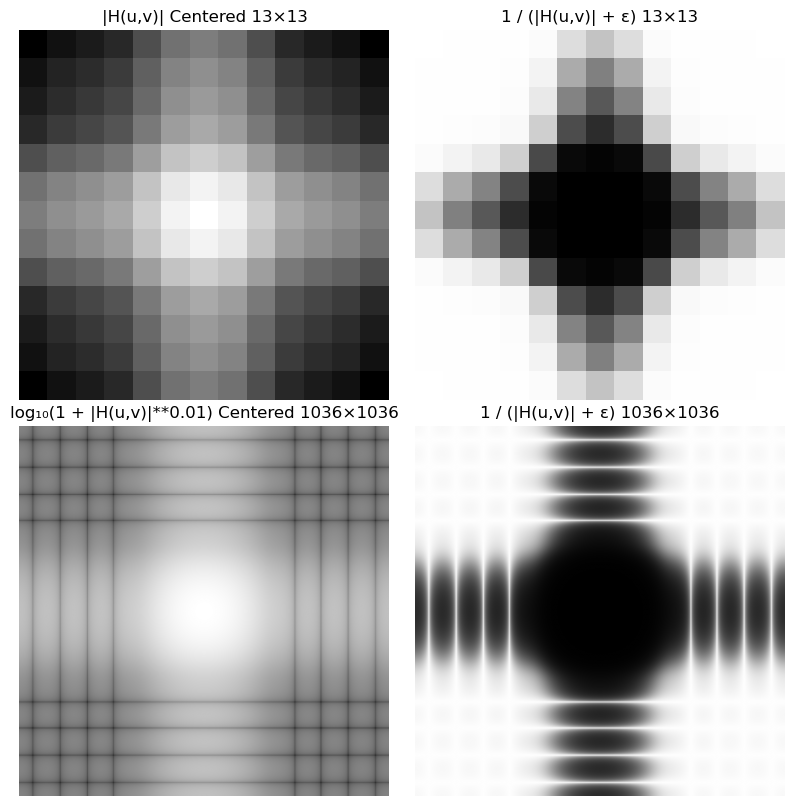

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# (i)
axes[0, 0].imshow(Huv_log, cmap='gray')
axes[0, 0].set_title('|H(u,v)| Centered 13×13')

# (ii)
axes[0, 1].imshow(inv_Huv_full_scale, cmap='gray')
axes[0, 1].set_title('1 / (|H(u,v)| + ε) 13×13')

# (iii)
axes[1, 0].imshow(padded_G_log, cmap='gray')
axes[1, 0].set_title('log₁₀(1 + |H(u,v)|**0.01) Centered 1036×1036')

# (iv)
axes[1, 1].imshow(inv_padded_G_abs_full_scale, cmap='gray')
axes[1, 1].set_title('1 / (|H(u,v)| + ε) 1036×1036')

for ax in axes.ravel():
    ax.axis('off')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.4)
plt.show()

### C. 

In [75]:
u = np.arange(-(Mpt-1)//2, (Mpt-1)//2 + 1)
v = np.arange(-(Mpt-1)//2, (Mpt-1)//2 + 1)
U, V = np.meshgrid(u, v)
expo = -(U**2 + V**2)

In [71]:
K = np.linspace(1e-6,1e-3,500)
errors = []
for k in K:
    H_cont = np.exp(k*expo)
    error = np.sum((H_cont - padded_G_abs)**2)
    errors.append(error)


In [96]:
k_opt = K[np.argmin(errors)]
print(f'Optimal k: {k_opt:.6f}')
print(f'Minimum Error: {min(errors):.6f}')

Optimal k: 0.000113
Minimum Error: 6.943127


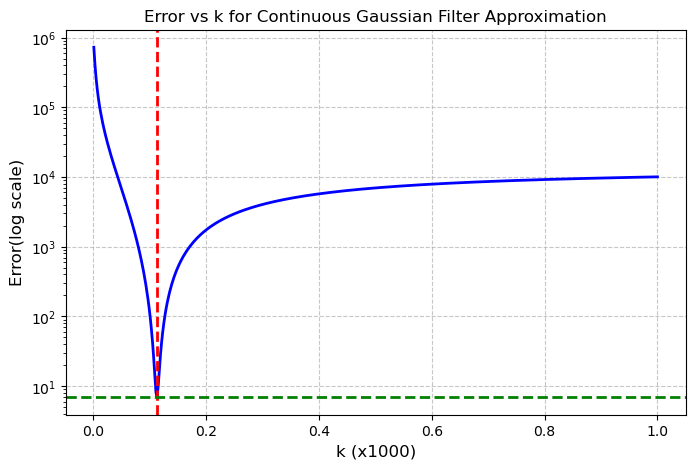

In [95]:
plt.figure(figsize=(8,5))
plt.plot(K*1e3, errors, color='blue', linewidth=2, label='Error')
plt.xlabel('k (x1000)', fontsize=12)
plt.yscale('log')
plt.ylabel('Error(log scale)', fontsize=12)
plt.axvline(x=k_opt*1e3, color='red', linestyle='--', linewidth=2)
plt.axhline(y=min(errors), color='green', linestyle='--', linewidth=2)
plt.title('Error vs k for Continuous Gaussian Filter Approximation', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.show()

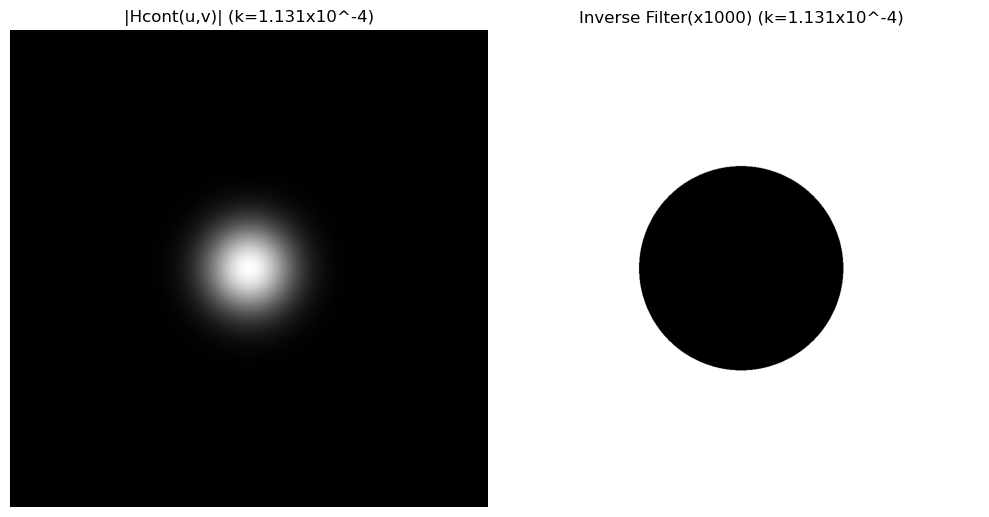

In [102]:
H_cont_opt = np.exp(k_opt*expo)
H_cont_opt = (H_cont_opt - np.min(H_cont_opt)) / (np.max(H_cont_opt) - np.min(H_cont_opt))
H_cont_opt = (H_cont_opt * 255).astype(np.uint8)
H_cont_opt_inv = 1/(H_cont_opt + 1e-3)
H_cont_opt_inv = (H_cont_opt_inv - np.min(H_cont_opt_inv)) / (np.max(H_cont_opt_inv) - np.min(H_cont_opt_inv))
H_cont_opt_inv = (H_cont_opt_inv * 255).astype(np.uint8)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(H_cont_opt, cmap='gray')
plt.title(f'|Hcont(u,v)| (k={k_opt * 10000:.3f}x10^-4)', fontsize=12)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(H_cont_opt_inv, cmap='gray')
plt.title(f'Inverse Filter(x1000) (k={k_opt*10000:.3f}x10^-4)', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

### D.

In [103]:
building_padded = np.pad(building,((6,6),(6,6),(0,0)), mode='constant', constant_values=0.0)
building_padded.shape

(1036, 1036, 3)

In [105]:

inv_dft_G_channels = []
for c in range(building_padded.shape[2]):
	fft_channel = np.fft.fft2(building_padded[:, :, c])
	filtered_channel = np.fft.ifft2(fft_channel * inv_padded_G)
	filtered_channel = np.abs(filtered_channel)
	inv_dft_G_channels.append(filtered_channel)

inv_dft_G = np.stack(inv_dft_G_channels, axis=2)
inv_dft_G = (inv_dft_G - np.min(inv_dft_G)) / (np.max(inv_dft_G) - np.min(inv_dft_G))
inv_dft_G = (inv_dft_G * 255).astype(np.uint8)

# Process each channel separately for continuous Gaussian inverse filter
inv_dft_G_cont_channels = []
for c in range(building_padded.shape[2]):
	fft_channel = np.fft.fft2(building_padded[:, :, c])
	filtered_channel = np.fft.ifft2(fft_channel * H_cont_opt_inv)
	filtered_channel = np.abs(filtered_channel)
	inv_dft_G_cont_channels.append(filtered_channel)

inv_dft_G_cont = np.stack(inv_dft_G_cont_channels, axis=2)
inv_dft_G_cont = (inv_dft_G_cont - np.min(inv_dft_G_cont)) / (np.max(inv_dft_G_cont) - np.min(inv_dft_G_cont))
inv_dft_G_cont = (inv_dft_G_cont * 255).astype(np.uint8)

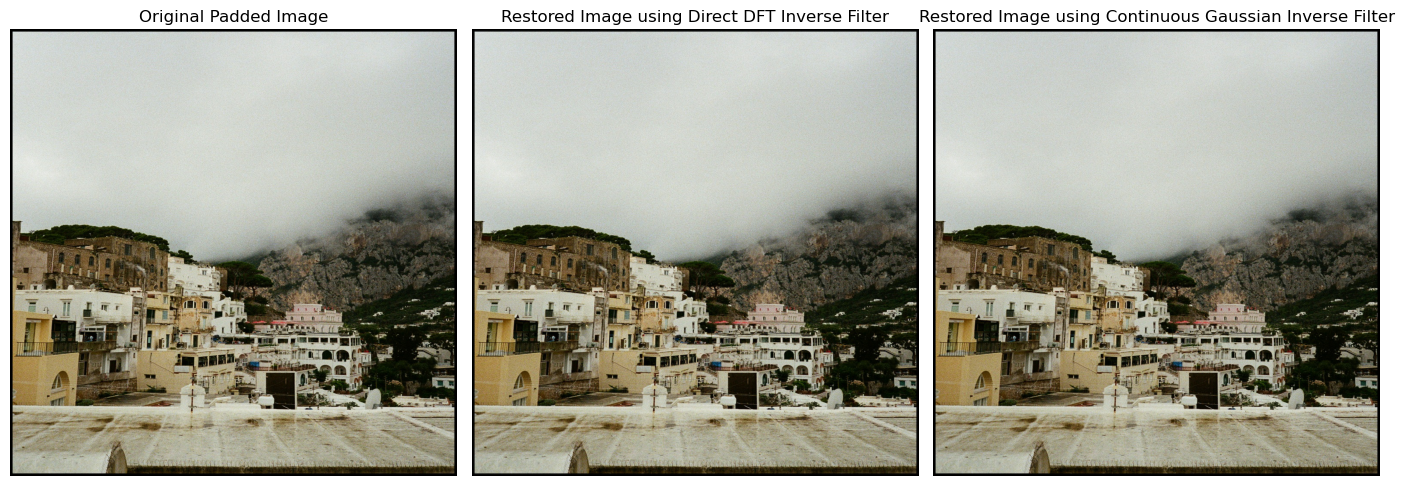

In [106]:
plt.figure(figsize=(14,15))
plt.subplot(1,3,1)
plt.imshow(building_padded)
plt.title("Original Padded Image", fontsize=12)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(inv_dft_G)
plt.title('Restored Image using Direct DFT Inverse Filter', fontsize=12)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(inv_dft_G_cont)
plt.title('Restored Image using Continuous Gaussian Inverse Filter', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

In [107]:
def compute_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

In [108]:
mean_squared_error_direct = compute_mse(building_padded, inv_dft_G)
mean_squared_error_continuous = compute_mse(building_padded, inv_dft_G_cont)
print(f'Mean Squared Error (Direct DFT Inverse Filter): {mean_squared_error_direct:.2f}')
print(f'Mean Squared Error (Continuous Gaussian Inverse Filter): {mean_squared_error_continuous:.2f}')

Mean Squared Error (Direct DFT Inverse Filter): 21.95
Mean Squared Error (Continuous Gaussian Inverse Filter): 15.60
